In [98]:
import torch
from nkland import NKLand
from nkland.landscape import default_rng

n = 32
k = 8
num_instances = 10
num_restarts = 5

max_iterations = 128

#landscapes = NKLand.random(n, k, additional_dims=(num_restarts, num_instances,))

init_rng = default_rng(12345)

interactions = NKLand.generate_interactions(n, k, additional_dims=(num_instances,), seed=init_rng)
interactions = interactions.expand(num_restarts, *[-1] * interactions.ndimension())

contributions = NKLand.generate_fitness_contributions(n, k, additional_dims=(num_instances,), seed=init_rng)
contributions = contributions.expand(num_restarts, *[-1] * contributions.ndimension())

landscapes = NKLand(interactions, contributions)


In [99]:
def get_neighbors(solutions: torch.Tensor) -> torch.Tensor:
    eyes = torch.eye(solutions.size(-1), dtype=torch.bool)
    return solutions ^ eyes

In [100]:
from dataclasses import dataclass


@dataclass
class Trajectory:
    strategy_name: str
    solutions: list[torch.Tensor]
    fitness: list[torch.Tensor]

    def last_solution(self) -> torch.Tensor:
        if len(self.solutions) == 0:
            raise ValueError("cannot get last solution of empty trajectory")
        return self.solutions[-1]

    def last_fitness(self) -> torch.Tensor:
        if len(self.fitness) == 0:
            raise ValueError("cannot get last fitness of empty trajectory")
        return self.fitness[-1]

    def append_point(self, solution: torch.Tensor, fitness: torch.Tensor):
        self.solutions.append(solution)
        self.fitness.append(fitness)
        return self

    def get_solutions(self) -> torch.Tensor:
        return torch.stack(self.solutions)

    def get_fitness(self) -> torch.Tensor:
        return torch.stack(self.fitness)

    @staticmethod
    def create(strategy_name: str, landscape: NKLand, *, seed: torch.Generator = None) -> "Trajectory":
        s0 = landscape.sample(seed=seed)
        f0 = landscape.evaluate(s0)
        return Trajectory(
            strategy_name = strategy_name,
            solutions = [s0],
            fitness = [f0],
        )


In [101]:
s0_rng = default_rng(99)


trajectory = Trajectory.create(
    strategy_name = "hill_climber",
    landscape = landscapes,
    seed = s0_rng,
)

for i in range(max_iterations):
    neighbors = get_neighbors(trajectory.last_solution())
    solutions = torch.cat((neighbors, trajectory.last_solution()), dim=-2)

    fitness = landscapes.evaluate(solutions)
    delta_fitness = fitness - trajectory.last_fitness().unsqueeze(-1)

    # Best Hill Climber
    max_indices = delta_fitness.argmax(dim=-1, keepdims=True)
    indices_expanded = max_indices.unsqueeze(-1).expand(*landscapes._additional_dims, 1, solutions.size(-1))
    best_solutions = torch.gather(solutions, -2, indices_expanded)

    trajectory.append_point(
        solution=best_solutions,
        fitness=torch.gather(fitness, -1, max_indices).squeeze(-1),
    )


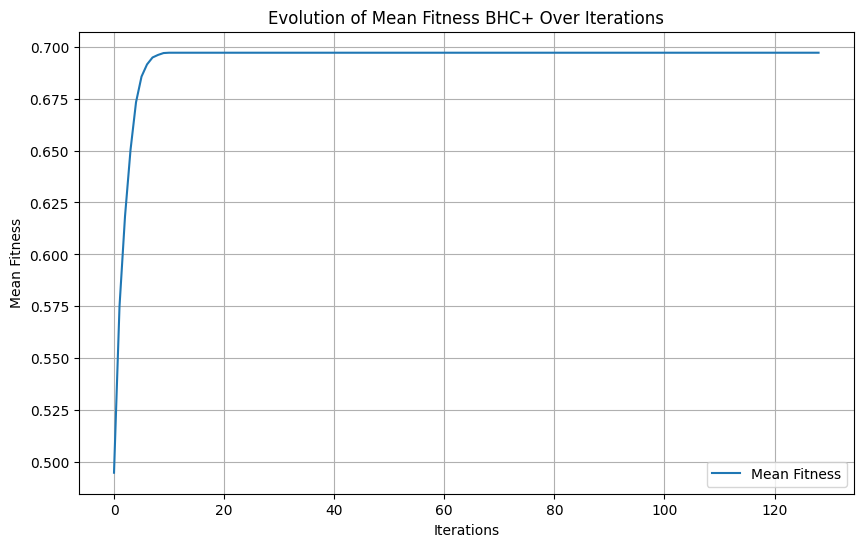

In [103]:
import matplotlib.pyplot as plt

# Compute mean fitness over all instances+restarts for each iteration
mean_fitness = torch.mean(trajectory.get_fitness(), dim=(-2, -1))

# Plot the mean fitness over number of iterations
plt.figure(figsize=(10, 6))
plt.plot(range(mean_fitness.numel()), mean_fitness.numpy(), label='Mean Fitness')
plt.xlabel('Iterations')
plt.ylabel('Mean Fitness')
plt.title('Evolution of Mean Fitness BHC+ Over Iterations')
plt.legend()
plt.grid(True)
plt.show()